# Data importing and cleaning for lstm training

In [58]:
!pip install datasets

In [59]:
import pandas as pd

df = pd.read_csv("hf://datasets/bitext/Bitext-customer-support-llm-chatbot-training-dataset/Bitext_Sample_Customer_Support_Training_Dataset_27K_responses-v11.csv")

In [60]:
df.head()

,flags,instruction,category,intent,response
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...


In [61]:
df.intent.unique()

array(['cancel_order', 'change_order', 'change_shipping_address',
       'check_cancellation_fee', 'check_invoice', 'check_payment_methods',
       'check_refund_policy', 'complaint', 'contact_customer_service',
       'contact_human_agent', 'create_account', 'delete_account',
       'delivery_options', 'delivery_period', 'edit_account',
       'get_invoice', 'get_refund', 'newsletter_subscription',
       'payment_issue', 'place_order', 'recover_password',
       'registration_problems', 'review', 'set_up_shipping_address',
       'switch_account', 'track_order', 'track_refund'], dtype=object)

**Only extracting three columns for easiness**

categories we have now are ==> 'contact_customer_service', 'get_refund', 'place_order'

In [62]:

filtered_df = df[df['intent'].isin(['contact_customer_service', 'get_refund', 'place_order'])]

filtered_df.head()

,flags,instruction,category,intent,response
7914,BL,I want help to speak to customer support,CONTACT,contact_customer_service,Happy to hear from you! I truly understand tha...
7915,BIL,do you have a free number to talk to customer ...,CONTACT,contact_customer_service,Thank you for reaching out! I understand your ...
7916,BLZ,I try to see what hours customer service aaila...,CONTACT,contact_customer_service,We're here for you! I'm aware that you would l...
7917,BILZ,do you have a mail to get in touch with cusome...,CONTACT,contact_customer_service,Happy to hear from you! I truly understand tha...
7918,BIL,where can I see what hours I can reach custome...,CONTACT,contact_customer_service,Happy to hear from you! I truly understand tha...


In [63]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2995 entries, 7914 to 19890
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   flags        2995 non-null   object
 1   instruction  2995 non-null   object
 2   category     2995 non-null   object
 3   intent       2995 non-null   object
 4   response     2995 non-null   object
dtypes: object(5)
memory usage: 140.4+ KB


In [64]:
filtered_df.dropna()

,flags,instruction,category,intent,response
7914,BL,I want help to speak to customer support,CONTACT,contact_customer_service,Happy to hear from you! I truly understand tha...
7915,BIL,do you have a free number to talk to customer ...,CONTACT,contact_customer_service,Thank you for reaching out! I understand your ...
7916,BLZ,I try to see what hours customer service aaila...,CONTACT,contact_customer_service,We're here for you! I'm aware that you would l...
7917,BILZ,do you have a mail to get in touch with cusome...,CONTACT,contact_customer_service,Happy to hear from you! I truly understand tha...
7918,BIL,where can I see what hours I can reach custome...,CONTACT,contact_customer_service,Happy to hear from you! I truly understand tha...
...,...,...,...,...,...
19886,BLQ,i want help to shop a product,ORDER,place_order,Glad you contacted to us for assistance with s...
19887,BLMP,I would like to earn several items,ORDER,place_order,Thank you for expressing your interest in acqu...
19888,BILQ,how to acquire a product,ORDER,place_order,Thank you for your interest in acquiring a pro...
19889,BILMQ,what do i need to do to earn several of ur item,ORDER,place_order,Thank you for your interest in earning several...


In [65]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [66]:

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preprocessing the sentences before training (tokenization and padding)

In [67]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(filtered_df['instruction'])
sequences = tokenizer.texts_to_sequences(filtered_df['instruction'])


max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)


label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(filtered_df['intent'])


print(f"Padded sequences shape: {padded_sequences.shape}")
print(f"Labels shape: {labels.shape}")

Padded sequences shape: (2995, 17)
Labels shape: (2995,)


# Model building and Training

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical


vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
num_classes = len(label_encoder.classes_)


labels = to_categorical(labels, num_classes=num_classes)


model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [69]:

history = model.fit(padded_sequences, labels, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
75/75 [==============================] - 25s 201ms/step - loss: 0.5206 - accuracy: 0.7826 - val_loss: 0.3205 - val_accuracy: 0.9900
Epoch 2/5
75/75 [==============================] - 11s 145ms/step - loss: 0.0229 - accuracy: 0.9958 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 3/5
75/75 [==============================] - 6s 75ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 4/5
75/75 [==============================] - 8s 102ms/step - loss: 0.0017 - accuracy: 0.9992 - val_loss: 0.0135 - val_accuracy: 0.9950
Epoch 5/5
75/75 [==============================] - 6s 75ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.0136 - val_accuracy: 1.0000


In [70]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 17, 100)           53200     
                                                                 
 lstm_6 (LSTM)               (None, 17, 128)           117248    
                                                                 
 dropout_6 (Dropout)         (None, 17, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 302419 (1.15 MB)
Trainable params: 30241

In [83]:
loss, accuracy = model.evaluate(padded_sequences, labels)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

94/94 [==============================] - 5s 50ms/step - loss: 0.0043 - accuracy: 1.0000
Loss: 0.0042974152602255344
Accuracy: 1.0


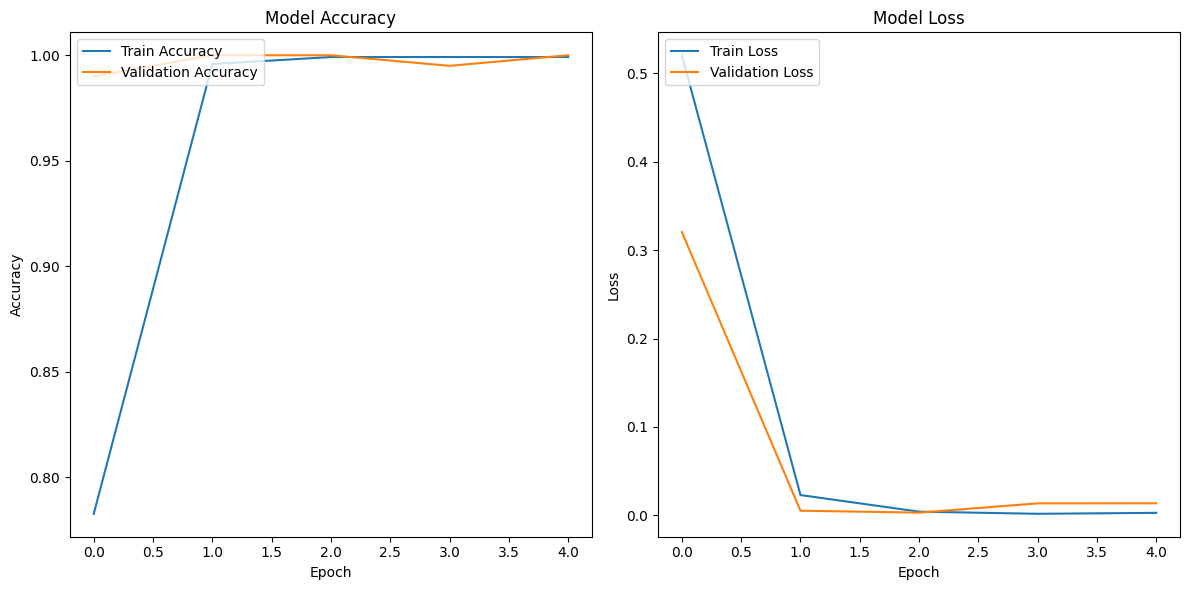

In [72]:
import matplotlib.pyplot as plt


def plot_history(history):

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')


    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()


plot_history(history)


# Necessary libraries installing for audio recognition

In [76]:
!sudo apt-get install portaudio19-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
portaudio19-dev is already the newest version (19.6.0-1.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [77]:
!pip install PyAudio

In [78]:
!pip install SpeechRecognition

# Now doing real classification by handling both audio and text

In [79]:
import nltk
from nltk.corpus import stopwords
import string
import speech_recognition as sr
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Download NLTK stopwords and punctuation
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join(char for char in text if char not in punctuation)
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Function to predict intent from user input
def predict_intent(input_text):
    # Preprocess the input
    processed_input = preprocess_text(input_text)

    # Tokenize and pad the input (assuming tokenizer, max_sequence_length, and model are defined)
    sequence = tokenizer.texts_to_sequences([processed_input])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)

    # Predict the intent
    prediction = model.predict(padded_sequence)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])

    return predicted_label[0]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [80]:
!pip install pydub

# Classifying from user Text

In [81]:
user_query=input("Enter your message: ")
print("\n\nI am classifying this into ==> ",predict_intent(user_query), "Category")

Enter your message: where is the support team. i want to talk
1/1 [==============================] - 2s 2s/step


I am classifying this into ==>  contact_customer_service Category


# Classifying from Audio

In [82]:
from pydub import AudioSegment
import speech_recognition as sr

# Function to convert MP3 to WAV and recognize speech
def recognize_speech_from_mp3(mp3_file):
    # Load MP3 file using pydub
    audio = AudioSegment.from_mp3(mp3_file)

    # Export as WAV (16-bit PCM format, which is required by SpeechRecognition)
    audio.export("audio.wav", format="wav")

    # Perform speech recognition on the converted WAV file
    recognizer = sr.Recognizer()
    with sr.AudioFile("audio.wav") as source:
        audio_data = recognizer.record(source)

    try:
        text = recognizer.recognize_google(audio_data)
        return text
    except sr.UnknownValueError:
        print("Could not understand audio")
    except sr.RequestError as e:
        print(f"Could not request results; {e}")

mp3_file = 'order.mp3'
recognized_text = recognize_speech_from_mp3(mp3_file)
print(f"Detected Text from audio: {recognized_text}\n")
print("\n\nI am classifying this into ==> ",predict_intent(recognized_text), "Category")

Detected Text from audio: I would like to place an order

1/1 [==============================] - 0s 48ms/step


I am classifying this into ==>  place_order Category
